# **How to deal with limited datasets**


In [3]:
!pip install metrics
!pip install nlpaug
!pip install textaugment

     |████████████████████████████████| 849kB 5.5MB/s 
  Created wheel for metrics: filename=metrics-0.3.3-py2.py3-none-any.whl size=17814 sha256=ef8a10538c25f7de1fe318c7b15d0585fb9b81d4d7aeefc7b37094543ddeecd8
  Stored in directory: /root/.cache/pip/wheels/38/e8/55/c4c648451a33a60920318eba4c5735088dbf78dc20d4277db0
  Created wheel for pathspec: filename=pathspec-0.5.5-cp37-none-any.whl size=24228 sha256=9afd20cf6ee57f30977c2c71d2a047f044766da765f8c80baa5c00ae0f8fb82c
  Stored in directory: /root/.cache/pip/wheels/d1/2e/6b/c67842adf3b13ea33ca3fe6a2a963622821ad647db724688e2
Successfully built metrics pathspec
ERROR: jupyterlab-pygments 0.1.2 has requirement pygments<3,>=2.4.1, but you'll have pygments 2.2.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1


     |████████████████████████████████| 399kB 4.4MB/s 
     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.0MB 8.3MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp37-none-any.whl size=15737 sha256=81fd6b5c9ef933f10ee5d404c4ad2ef0bf277adaa364d47e857c71c2b986934c
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
Successfully built googletrans


In [3]:
import numpy as np 
import pandas as pd
import nltk
import re
import seaborn as sns
import random

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE

from keras.utils import to_categorical
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.models import Sequential

from matplotlib import pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from textaugment import Wordnet
from textaugment import EDA
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas

from wordcloud import WordCloud

In [4]:
#loading the data
path = 'drive/MyDrive/'
data = pd.read_csv(path+'all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

In [7]:
len(data)

4840

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
PONCTUATION = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

def text_prepare(text):
    text =  text.lower()
    text =  re.sub(PONCTUATION," ",text)
    text =  re.sub(BAD_SYMBOLS,"",text)
    text =  " ".join([word for word in word_tokenize(text) if word not in stop_words])
    text = text.strip()
    return text

In [11]:
texts = data['text']
texts

0       According to Gran , the company has no plans t...
1       Technopolis plans to develop in stages an area...
2       The international electronic industry company ...
3       With the new production plant the company woul...
4       According to the company 's updated strategy f...
                              ...                        
4841    LONDON MarketWatch -- Share prices ended lower...
4842    Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843    Operating profit fell to EUR 35.4 mn from EUR ...
4844    Net sales of the Paper segment decreased to EU...
4845    Sales in Finland decreased by 10.5 % in Januar...
Name: text, Length: 4840, dtype: object

In [9]:
data['text'] = data['text'].apply(text_prepare)
texts = data['text']
texts

0       according gran company plans move production r...
1       technopolis plans develop stages area less 100...
2       international electronic industry company elco...
3       new production plant company would increase ca...
4       according company updated strategy years 20092...
                              ...                        
4841    london marketwatch share prices ended lower lo...
4842    rinkuskiai beer sales fell 65 per cent 416 mil...
4843    operating profit fell eur 354 mn eur 688 mn 20...
4844    net sales paper segment decreased eur 2216 mn ...
4845    sales finland decreased 105 january sales outs...
Name: text, Length: 4840, dtype: object

In [13]:
sentiment = data['sentiment']
sentiment

0        neutral
1        neutral
2       negative
3       positive
4       positive
          ...   
4841    negative
4842     neutral
4843    negative
4844    negative
4845    negative
Name: sentiment, Length: 4840, dtype: object

In [14]:
texts[0]

'according gran company plans move production russia although company growing'

In [15]:
sentiment[0]

'neutral'

In [10]:
sentiment_changer = {"neutral":0, "negative":1,"positive":2}
data.sentiment = data.sentiment.map(sentiment_changer)

In [29]:
x_train,x_test,y_train,y_test = train_test_split(data.text,data.sentiment,test_size = 0.2 , random_state = 0)

In [20]:
def tokenize_features(X_train, X_test):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5, token_pattern= '(\S+)' ) 
    tfidf_vectorizer = tfidf_vectorizer.fit(X_train)
    X_train_tfidf = tfidf_vectorizer.transform(X_train)
    X_test_tfidf  = tfidf_vectorizer.transform(X_test)
    vocab = tfidf_vectorizer.vocabulary_
    return X_train_tfidf.todense(),  X_test_tfidf.todense(), vocab

In [30]:
X_train_tfidf,  X_test_tfidf , vocab = tokenize_features(x_train,x_test)

**1.Combining simple models**

 In order to combine the models performances, we would compute weighted averages of the various predictions for the different classes. Therefore the final prediction would be the class with the highest weighted average.

In [22]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [23]:
# prepare models
models = []
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC(probability=True)))
#models.append(('XGB', XGBClassifier()))

In [31]:
seed = 5
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  print('fitting the',name,'model')
  kfold = model_selection.KFold(n_splits=10, random_state=seed)
  cv_results = model_selection.cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

fitting the KNN model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.637143 (0.024106)
fitting the CART model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.652367 (0.019079)
fitting the RF model


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.737346 (0.013558)


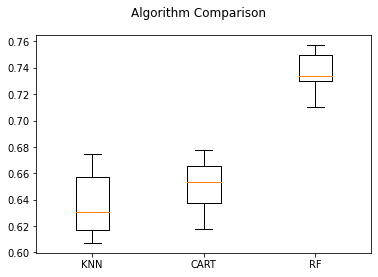

In [32]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [33]:
preds0 = pd.DataFrame()
preds1 = pd.DataFrame()
preds2 = pd.DataFrame()

for i, m in enumerate(models):
    model = m[1]
    model.fit(X_train_tfidf, y_train)
    pred = model.predict_proba(X_test_tfidf)
    preds0[i] = pred[:,0]
    preds1[i] = pred[:,1]
    preds2[i] = pred[:,2]

In [34]:
weights = [0.5, 1,1]
preds0['weighted_pred'] = (preds0 * weights).sum(axis=1) / sum(weights)
preds1['weighted_pred'] = (preds1 * weights).sum(axis=1) / sum(weights)
preds2['weighted_pred'] = (preds2 * weights).sum(axis=1) / sum(weights)

In [35]:
preds0.head()

,0,1,2,weighted_pred
0,1.0,0.0,0.735,0.494
1,0.8,1.0,0.950,0.940
2,1.0,1.0,0.410,0.764
3,1.0,1.0,0.830,0.932
4,1.0,0.0,0.820,0.528


In [35]:
preds1.head()

,0,1,2,weighted_pred
0,0.0,0.0,0.01,0.004
1,0.2,0.0,0.02,0.048
2,0.0,0.0,0.49,0.196
3,0.0,0.0,0.00,0.000
4,0.0,1.0,0.12,0.448


In [36]:
preds2.head()

,0,1,2,weighted_pred
0,0.0,0.0,0.2225,0.089
1,0.0,0.0,0.0200,0.008
2,0.0,0.0,0.0900,0.036
3,0.0,0.0,0.2000,0.080
4,0.0,0.0,0.0800,0.032


In [36]:
from mlxtend.classifier import StackingClassifier
m = StackingClassifier(
    classifiers=[
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier()
    ],
    use_probas=True,
    meta_classifier=XGBClassifier(max_depth=2)
)
m.fit(X_train_tfidf, y_train),

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


(StackingClassifier(average_probas=False,
                    classifiers=[KNeighborsClassifier(algorithm='auto',
                                                      leaf_size=30,
                                                      metric='minkowski',
                                                      metric_params=None,
                                                      n_jobs=None, n_neighbors=5,
                                                      p=2, weights='uniform'),
                                 DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impur

In [37]:
preds0['StackingClassifier_pred'] = model.predict_proba(X_test_tfidf)[:,0]
preds1['StackingClassifier_pred'] = model.predict_proba(X_test_tfidf)[:,1]
preds2['StackingClassifier_pred'] = model.predict_proba(X_test_tfidf)[:,2]

In [39]:
preds0.head()

,0,1,2,weighted_pred,StackingClassifier_pred
0,1.0,1.0,0.7675,0.907,0.7675
1,0.8,1.0,0.9600,0.944,0.9600
2,1.0,1.0,0.4200,0.768,0.4200
3,1.0,1.0,0.8000,0.920,0.8000
4,1.0,0.0,0.8000,0.520,0.8000


In [40]:
preds1.head()

,0,1,2,weighted_pred,StackingClassifier_pred
0,0.0,0.0,0.01,0.004,0.01
1,0.2,0.0,0.02,0.048,0.02
2,0.0,0.0,0.49,0.196,0.49
3,0.0,0.0,0.00,0.000,0.00
4,0.0,1.0,0.12,0.448,0.12


In [41]:
preds2.head()

,0,1,2,weighted_pred,StackingClassifier_pred
0,0.0,0.0,0.2225,0.089,0.2225
1,0.0,0.0,0.0200,0.008,0.0200
2,0.0,0.0,0.0900,0.036,0.0900
3,0.0,0.0,0.2000,0.080,0.2000
4,0.0,0.0,0.0800,0.032,0.0800


In [42]:
pred = pd.DataFrame()
pred[0] = preds0.StackingClassifier_pred
pred[1] = preds1.StackingClassifier_pred
pred[2] = preds2.StackingClassifier_pred

In [43]:
pred['best_pred'] = pred.idxmax(axis=1)
pred.head()

,0,1,2,best_pred
0,0.7675,0.01,0.2225,0
1,0.9600,0.02,0.0200,0
2,0.4200,0.49,0.0900,1
3,0.8000,0.00,0.2000,0
4,0.8000,0.12,0.0800,0


In [44]:
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(m, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
results.append(cv_results)
names.append(name)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.651590 (0.018416)


**2.Balancing the dataset**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


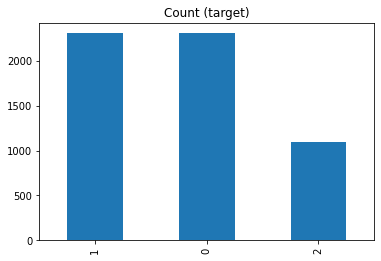

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X_train_tfidf, y_train)

df = pd.DataFrame(X_sm)
df['target'] = y_sm
df['target'].value_counts().plot(kind='bar', title='Count (target)');

In [46]:
seed = 5
scoring = 'accuracy'
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(XGBClassifier(max_depth=2), X_sm, y_sm, cv=kfold, scoring=scoring)
msg = ": %f (%f)" % ( cv_results.mean(), cv_results.std())
print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


: 0.741156 (0.045756)


**3.Transfer learning**

In [38]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.1MB/s 
     |████████████████████████████████| 3.3MB 36.5MB/s 
     |████████████████████████████████| 901kB 38.0MB/s 


In [40]:
import numpy as np
import re
import pandas as pd
import nltk
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [41]:
device = torch.device("cuda")

In [42]:
!pip install tensorflow==1.15.0
!pip install pyspellchecker
!pip install pandas-profiling --ignore-installed

     |████████████████████████████████| 412.3MB 43kB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 512kB 36.9MB/s 
     |████████████████████████████████| 3.8MB 27.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=809100dd318c9c05754b09c3f36370ad2033b7e77085a354b7867514d12f5c85
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

     |████████████████████████████████| 2.7MB 4.0MB/s 
     |████████████████████████████████| 256kB 6.0MB/s 
     |████████████████████████████████| 10.3MB 31.3MB/s 
     |████████████████████████████████| 143kB 36.3MB/s 
     |████████████████████████████████| 15.3MB 146kB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 307kB 34.7MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 9.9MB 30.8MB/s 
     |████████████████████████████████| 645kB 33.3MB/s 
     |████████████████████████████████| 112kB 38.8MB/s 
     |████████████████████████████████| 3.1MB 27.3MB/s 
     |████████████████████████████████| 27.4MB 110kB/s 
     |████████████████████████████████| 286kB 35.6MB/s 
     |████████████████████████████████| 10.1MB 29.0MB/s 
     |████████████████████████████████| 1.1MB 30.7MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 3.0MB 26.7MB/s

Restart the kernel before computing the following cell

In [1]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import datetime
import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport

import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from spellchecker import SpellChecker

from tqdm.auto import tqdm
from tqdm import tqdm_notebook

from IPython.display import display, Markdown, clear_output
from termcolor import colored
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.offline import plot, iplot
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook"

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=369):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.loc[perm[:train_end]]
    validate = df.loc[perm[train_end:validate_end]]
    test = df.loc[perm[validate_end:]]
    return train, validate, test

In [27]:
data.sentiment = data.sentiment.map(sentiment_changer)
data.head()

,sentiment,text
0,0,according gran company plans move production r...
1,0,technopolis plans develop stages area less 100...
2,1,international electronic industry company elco...
3,2,new production plant company would increase ca...
4,2,according company updated strategy years 20092...


In [12]:
train_df, val_df, test_df = train_validate_test_split(data)

print('Train: {}, Validation: {}, Test: {}'.format(train_df.shape, val_df.shape, test_df.shape))

train_text = train_df['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = np.asarray(pd.get_dummies(train_df['sentiment']), dtype = np.int8)

val_text = val_df['text'].tolist()
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = np.asarray(pd.get_dummies(val_df['sentiment']), dtype = np.int8)

test_text = test_df['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(test_df['sentiment']), dtype = np.int8)

Train: (2904, 2), Validation: (968, 2), Test: (968, 2)


Here we would use a Pre-trained Embedding model. This latter is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It takes variable length English text as input and outputs a 512-dimensional vector. 

In [13]:
#embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
print("Embedding size: ",embed_size)

Embedding size:  512


In [14]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), 
                 signature="default", as_dict=True)["default"]

category_counts = 3
input_text = layers.Input(shape=(1,), dtype="string")
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
x = layers.Dense(256, activation='relu')(embedding)
x = layers.Dropout(0.7)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(category_counts, activation='softmax')(x)

model_sa = Model(inputs=[input_text], outputs=x)

# we are selecting Adam optimizer 
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model_sa.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_sa.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda (Lambda)              (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387   

In [16]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model_sa.fit(train_text, train_label,
                            validation_data=(val_text, val_label),
                            epochs=100,
                            batch_size=32,
                            shuffle=True)
    model_sa.save_weights('best_model.h5')

Train on 2904 samples, validate on 968 samples
Epoch 1/100
2904/2904 [==============================] - 4s 1ms/sample - loss: 1.0480 - acc: 0.5100 - val_loss: 0.9834 - val_acc: 0.6002
Epoch 2/100
2904/2904 [==============================] - 1s 480us/sample - loss: 0.9561 - acc: 0.5902 - val_loss: 0.9154 - val_acc: 0.6002
Epoch 3/100
2904/2904 [==============================] - 1s 476us/sample - loss: 0.9160 - acc: 0.5913 - val_loss: 0.8854 - val_acc: 0.6002
Epoch 4/100
2904/2904 [==============================] - 1s 483us/sample - loss: 0.8922 - acc: 0.5923 - val_loss: 0.8626 - val_acc: 0.6002
Epoch 5/100
2904/2904 [==============================] - 1s 491us/sample - loss: 0.8699 - acc: 0.5961 - val_loss: 0.8421 - val_acc: 0.6023
Epoch 6/100
2904/2904 [==============================] - 1s 477us/sample - loss: 0.8483 - acc: 0.6064 - val_loss: 0.8250 - val_acc: 0.6157
Epoch 7/100
2904/2904 [==============================] - 1s 488us/sample - loss: 0.8318 - acc: 0.6078 - val_loss: 0.8096 

In [17]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model_sa.load_weights('best_model.h5')
    _, train_acc = model_sa.evaluate(train_text, train_label)
    _, test_acc = model_sa.evaluate(test_text, test_label)

clear_output()
display(Markdown('__Train Accuracy__: {}, __Test Accuracy__: {}'.format(round(train_acc,4), round(test_acc,4))))

__Train Accuracy__: 0.8495000004768372, __Test Accuracy__: 0.6818000078201294

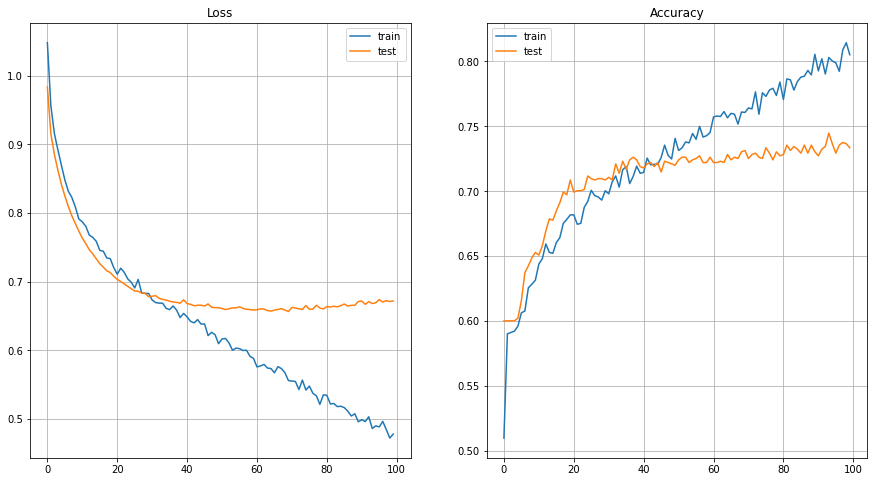

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(15, 8)
ax1.set_title('Loss')
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='test')
ax1.legend()
ax1.grid()

ax2.set_title('Accuracy')
ax2.plot(history.history['acc'], label='train')
ax2.plot(history.history['val_acc'], label='test')
ax2.legend()
ax2.grid()
plt.show()

In [20]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model_sa.load_weights('best_model.h5')
    predicts = model_sa.predict(test_text, batch_size=32)

categories = train_df['sentiment'].unique().tolist()

predict_logits = predicts.argmax(axis=1)
test_df['predicted'] = [categories[i] for i in predict_logits]

def highlight_rows(x):
    if x['sentiment'] != x['predicted']:
        return ['background-color: #d65f5f']*3
    else:
        return ['background-color: lightgreen']*3

clear_output()
display(test_df.head(5).style.apply(highlight_rows, axis=1))

,sentiment,text,predicted
3376,0,total number voting rights 74 612 523,2
2388,0,according company layoffs temporary,0
1700,2,viking line head jan kaarstroem told tt company ferries well equipped handle ice passengers safe,0
3639,0,beginning negotiations estimated number reductions 50 maximum,2
1588,2,renzo piano building design wonderful addition london skyline says noud veeger evp area director central north europe kone,2


**4.Transfer learning + Data augmentation**

In [21]:
!pip install nlpaug==1.1.3
!pip install textaugment

     |████████████████████████████████| 143kB 4.0MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.16.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: chardet 4.0.0
    Uninstalling chardet-4.0.0:
      Successfully uninstalled chardet-4.0.0


In [22]:
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas

In [23]:
path = 'drive/MyDrive/'
data = pd.read_csv(path+'all-data.csv', encoding='latin-1', names=['sentiment', 'text'])
data.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [24]:
def aug(text):
    aug  = naw.SynonymAug(aug_src='wordnet')
    aug1 = naw.RandomWordAug()
    #aug2 = nas.AbstSummAug()
    return aug1.augment(aug.augment(text))

In [25]:
data_negative = data[data.sentiment=='negative']
aug_neg_texys = list()
for text in data_negative.text:    
    for iter in range(2):
        aug_neg_texys.append(aug(text))
data_negative = data_negative.reset_index(drop=True)

data_positive = data[data.sentiment=='positive']
aug_pos_texys = list()
for text in data_positive.text:    
    for iter in range(1):
        aug_pos_texys.append(aug(text))
data_positive = data_positive.reset_index(drop=True)

data_neutral = data[data.sentiment=='neutral']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
for text in aug_pos_texys:
    new = {'sentiment':'positive','text':text}
    data_positive = data_positive.append(new, ignore_index=True)
for text in aug_neg_texys:
    new = {'sentiment':'negative','text':text}
    data_negative = data_negative.append(new, ignore_index=True)
 
aug_data = pd.concat([data_negative, data_positive,data_neutral])
aug_data.head()

,sentiment,text
0,negative,The international electronic industry company ...
1,negative,A tinyurl link takes users to a scamming site ...
2,negative,"Compared with the FTSE 100 index , which rose ..."
3,negative,"Compared with the FTSE 100 index , which rose ..."
4,negative,One of the challenges in the oil production in...


In [27]:
aug_data.sentiment = aug_data.sentiment.map(sentiment_changer)

In [95]:
aug_data.head()

,sentiment,text
0,1,The international electronic industry company ...
1,1,A tinyurl link takes users to a scamming site ...
2,1,"Compared with the FTSE 100 index , which rose ..."
3,1,"Compared with the FTSE 100 index , which rose ..."
4,1,One of the challenges in the oil production in...


In [28]:
aug_data = aug_data.sample(frac=1).reset_index(drop=True)
aug_data.head()

,sentiment,text
0,0,The Filter Tips cover the volume range from 0....
1,2,Xerox Enso upwards to cut iGen3 to the short -...
2,0,The total investment necessary will be EUR40m ...
3,1,The production is to be liquidated before June...
4,0,"Following the registration , the number of iss..."


In [29]:
train_df, val_df, test_df = train_validate_test_split(aug_data)

print('Train: {}, Validation: {}, Test: {}'.format(train_df.shape, val_df.shape, test_df.shape))

train_text = train_df['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = np.asarray(pd.get_dummies(train_df['sentiment']), dtype = np.int8)

val_text = val_df['text'].tolist()
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = np.asarray(pd.get_dummies(val_df['sentiment']), dtype = np.int8)

test_text = test_df['text'].tolist()
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = np.asarray(pd.get_dummies(test_df['sentiment']), dtype = np.int8)


category_counts = 3
input_text = layers.Input(shape=(1,), dtype="string")
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
x = layers.Dense(256, activation='relu')(embedding)
x = layers.Dropout(0.7)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(category_counts, activation='softmax')(x)

model_sa = Model(inputs=[input_text], outputs=x)

# we are selecting Adam optimizer 
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

model_sa.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_sa.summary()

Train: (4450, 2), Validation: (1483, 2), Test: (1484, 2)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387 

In [30]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model_sa.fit(train_text, train_label,
                            validation_data=(val_text, val_label),
                            epochs=100,
                            batch_size=32,
                            shuffle=True)
    model_sa.save_weights('best_model.h5')

Train on 4450 samples, validate on 1483 samples
Epoch 1/100
4450/4450 [==============================] - 4s 928us/sample - loss: 1.0828 - acc: 0.3899 - val_loss: 1.0654 - val_acc: 0.4693
Epoch 2/100
4450/4450 [==============================] - 2s 545us/sample - loss: 1.0515 - acc: 0.4319 - val_loss: 1.0241 - val_acc: 0.4909
Epoch 3/100
4450/4450 [==============================] - 2s 535us/sample - loss: 1.0124 - acc: 0.4706 - val_loss: 0.9762 - val_acc: 0.5044
Epoch 4/100
4450/4450 [==============================] - 2s 555us/sample - loss: 0.9753 - acc: 0.4944 - val_loss: 0.9323 - val_acc: 0.5448
Epoch 5/100
4450/4450 [==============================] - 2s 543us/sample - loss: 0.9480 - acc: 0.5157 - val_loss: 0.9004 - val_acc: 0.5529
Epoch 6/100
4450/4450 [==============================] - 2s 559us/sample - loss: 0.9207 - acc: 0.5335 - val_loss: 0.8731 - val_acc: 0.5664
Epoch 7/100
4450/4450 [==============================] - 2s 540us/sample - loss: 0.8997 - acc: 0.5564 - val_loss: 0.85

In [31]:
# load the saved model
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model_sa.load_weights('best_model.h5')
    _, train_acc = model_sa.evaluate(train_text, train_label)
    _, test_acc = model_sa.evaluate(test_text, test_label)

clear_output()
display(Markdown('__Train Accuracy__: {}, __Test Accuracy__: {}'.format(round(train_acc,4), round(test_acc,4))))

__Train Accuracy__: 0.8391000032424927, __Test Accuracy__: 0.6899999976158142

 Transfer learning for sentiment analysis can be hard given that knowledge learned from one topic may not be not broad or general enough to perform well on the target or downstream tasks.

In [71]:
models = ['KNN','CART','RF','NN ','NN + data augmentation','combined models','transfer learning','transfer learning + data augmentation']
acc = [63,65,73,72,95,66,71,74]

Text(0, 0.5, 'Prediction accuracy')

<Figure size 432x288 with 0 Axes>

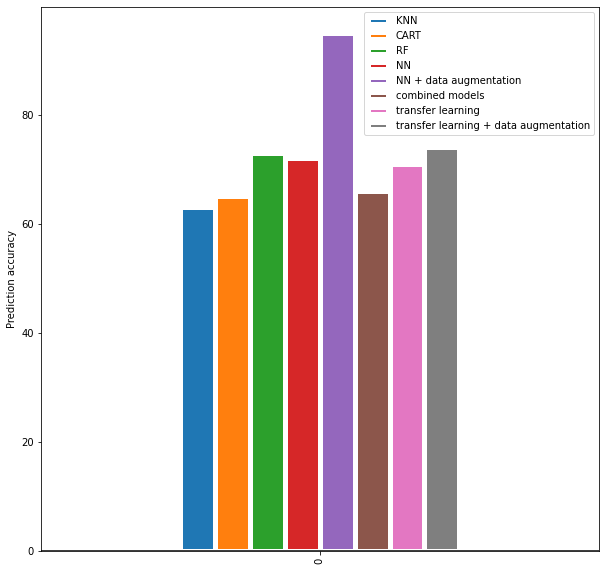

In [89]:
table = pd.DataFrame([acc], columns=models)
plt.figure()
table.plot(kind='bar', edgecolor='white', linewidth=5,figsize=(10,10))
plt.axhline(0, color="k")
plt.ylabel("Prediction accuracy")